In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from utils_ import reduce_mem_usage

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
images_path = Path('./images')
anno_path = Path('./annotations')

In [3]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [61]:
df_train = generate_train_df(anno_path)
df_train=reduce_mem_usage(df_train)

Memory usage of dataframe is 0.23 MB
Memory usage after optimization is: 0.14 MB
Decreased by 37.5%


In [5]:
df_train['class'].unique()

array(['cat', 'dog'], dtype=object)

In [6]:
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [62]:
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images\Cats_Test0.png,233,350,cat,83,29,197,142
1,images\Cats_Test1.png,500,500,dog,128,22,240,222
2,images\Cats_Test10.png,500,375,dog,157,56,264,116
3,images\Cats_Test100.png,500,375,cat,142,145,206,209
4,images\Cats_Test1000.png,335,500,cat,36,14,289,312
...,...,...,...,...,...,...,...,...
3681,images\Cats_Test995.png,500,375,dog,98,46,179,134
3682,images\Cats_Test996.png,500,335,cat,375,53,458,134
3683,images\Cats_Test997.png,500,333,cat,192,88,310,212
3684,images\Cats_Test998.png,375,500,cat,145,37,257,165


In [8]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

In [9]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [10]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

In [63]:
x=df_train.iloc[0]
np.array([x[5],x[4],x[7],x[6]])

array([ 29,  83, 142, 197], dtype=int16)

In [60]:
df_train.iloc[0]

index                                   0
filename            images\Cats_Test0.png
width                                 233
height                                350
class                                   0
xmin                                   83
ymin                                   29
xmax                                  197
ymax                                  142
new_path    images_resized\Cats_Test0.png
new_bb        [24.0, 158.0, 121.0, 378.0]
Name: 0, dtype: object

In [11]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [12]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [13]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,images\Cats_Test0.png,233,350,0,83,29,197,142,images_resized\Cats_Test0.png,"[24.0, 158.0, 121.0, 378.0]"
1,images\Cats_Test1.png,500,500,1,128,22,240,222,images_resized\Cats_Test1.png,"[13.0, 114.0, 132.0, 214.0]"
2,images\Cats_Test10.png,500,375,1,157,56,264,116,images_resized\Cats_Test10.png,"[44.0, 140.0, 92.0, 235.0]"
3,images\Cats_Test100.png,500,375,0,142,145,206,209,images_resized\Cats_Test100.png,"[116.0, 127.0, 167.0, 184.0]"
4,images\Cats_Test1000.png,335,500,0,36,14,289,312,images_resized\Cats_Test1000.png,"[8.0, 47.0, 186.0, 385.0]"


In [68]:
im = cv2.imread(str(df_train.values[60][0]))
bb = create_bb_array(df_train.values[60])
print(im.shape)

(311, 500, 3)


In [69]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 50., 125., 172., 256.], dtype=float32)

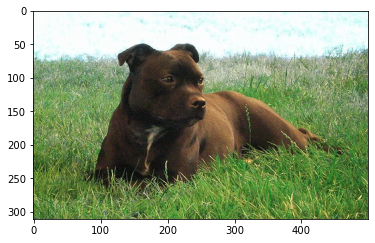

In [70]:
plt.imshow(im)

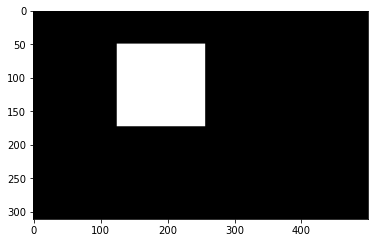

In [71]:
plt.imshow(Y, cmap='gray')

In [18]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [19]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [20]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [21]:
df_train.values[70]

array([WindowsPath('images/Cats_Test1060.png'), '500', '375', 1, 79, 1,
       268, 267, 'images_resized\\Cats_Test1060.png',
       array([  0.,  70., 213., 239.], dtype=float32)], dtype=object)

In [22]:
df_train.shape

(3686, 10)

images_resized\Cats_Test1024.png


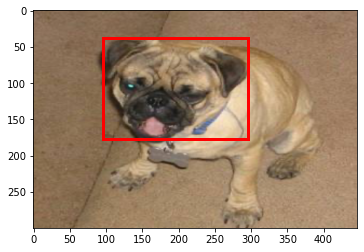

In [23]:
number = 30
im = cv2.imread(str(df_train.values[number][8]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[number][9])

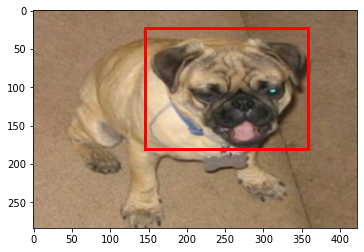

In [24]:
im, bb = transformsXY(str(df_train.values[number][8]),df_train.values[number][9],True )
show_corner_bb(im, bb)

In [25]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [27]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [41]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [42]:
np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])[0]

array([0.485, 0.456, 0.406])

In [43]:
batch_size = 8
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [44]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [36]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
epochs = 10

In [37]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_cla`ss, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 1.103 val_loss 0.979 val_acc 0.612
train_loss 0.916 val_loss 1.171 val_acc 0.656
train_loss 0.851 val_loss 0.815 val_acc 0.663
train_loss 0.816 val_loss 0.942 val_acc 0.657
train_loss 0.803 val_loss 0.793 val_acc 0.664
train_loss 0.791 val_loss 0.809 val_acc 0.663
train_loss 0.794 val_loss 0.801 val_acc 0.660
train_loss 0.784 val_loss 0.794 val_acc 0.664
train_loss 0.788 val_loss 0.790 val_acc 0.664
train_loss 0.783 val_loss 0.780 val_acc 0.665


In [46]:
# resizing test image
im = read_image('./images_resized/Cats_Test43.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('./road_signs_test/Cats_Test43.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [48]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./road_signs_test/Cats_Test43.png'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [49]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [50]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 0.1205,  1.1926, -7.1473, -7.3671]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[ 22.3152, 111.5415, 171.4182, 296.2017]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [51]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([1.1926], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))

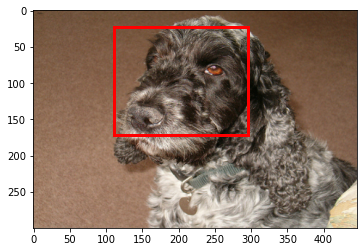

In [52]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])